In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader
from torchviz import make_dot
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import re

from sklearn import svm
from sklearn.model_selection import train_test_split

import glob
import os
import time
import sys
import wandb
import json
from tqdm.notebook import tqdm

sys.path.append("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/training/models")
from Binary_classification import Binary_classification

In [2]:
class DataSet():
    def __init__(self, data, label):
        self.label = label
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [3]:
weight_path = "/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/training/save_dir/partial_area_removal_02.pth"
weight_para = torch.load(weight_path, map_location=torch.device('cpu'))

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
print(f"使用デバイス: {device}")

使用デバイス: cuda:0


In [5]:
model = Binary_classification(latent=100, input_depth=30, input_height=100, input_width=100)
model.load_state_dict(weight_para)
model.to(device)
model.eval()

Binary_classification(
  (features): Sequential(
    (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (11): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (

In [6]:
summary(model.to(device), (1, 30, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 15, 50, 50]           1,040
       BatchNorm3d-2       [-1, 16, 15, 50, 50]              32
              ReLU-3       [-1, 16, 15, 50, 50]               0
            Conv3d-4        [-1, 32, 7, 25, 25]          32,800
       BatchNorm3d-5        [-1, 32, 7, 25, 25]              64
              ReLU-6        [-1, 32, 7, 25, 25]               0
         MaxPool3d-7        [-1, 32, 3, 12, 12]               0
            Conv3d-8        [-1, 32, 3, 12, 12]          27,680
       BatchNorm3d-9        [-1, 32, 3, 12, 12]              64
             ReLU-10        [-1, 32, 3, 12, 12]               0
           Conv3d-11        [-1, 16, 1, 10, 10]          13,840
             ReLU-12        [-1, 16, 1, 10, 10]               0
          Flatten-13                 [-1, 1600]               0
           Linear-14                  [

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [8]:
bubble_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/slide_bubble.npy")
removal_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/all_data_after_bubble_removal.npy")

# バブルのラベルは1、非バブルのラベルは0
bubble_label = [1] * len(bubble_data)
removal_label = [0] * len(removal_data)

In [9]:
bubble_test_val = int(len(bubble_data)/10)
removal_test_val = int(len(removal_data)/10)

print(bubble_test_val)
print(removal_test_val)

27
538


In [10]:
a = [0, 1, 2, 3,4,5,6,7,8,9,10]
b = 3
print(a[-b:])

[8, 9, 10]


In [11]:
# bubble_data = bubble_data[bubble_cut_val:]
# removal_data = removal_data[removal_cut_val:]
# ↑これの逆！　⬇️

bubble_data = bubble_data[:bubble_test_val]
removal_data = removal_data[:removal_test_val]
print(len(bubble_data))
print(len(removal_data))

27
538


In [12]:
bubble_label = [1] * len(bubble_data)
removal_label = [0] * len(removal_data)

print(len(bubble_label))
print(len(removal_label))

27
538


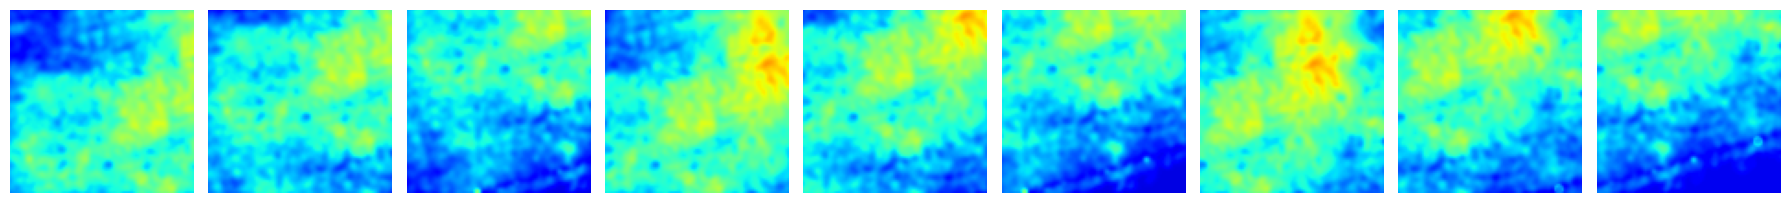

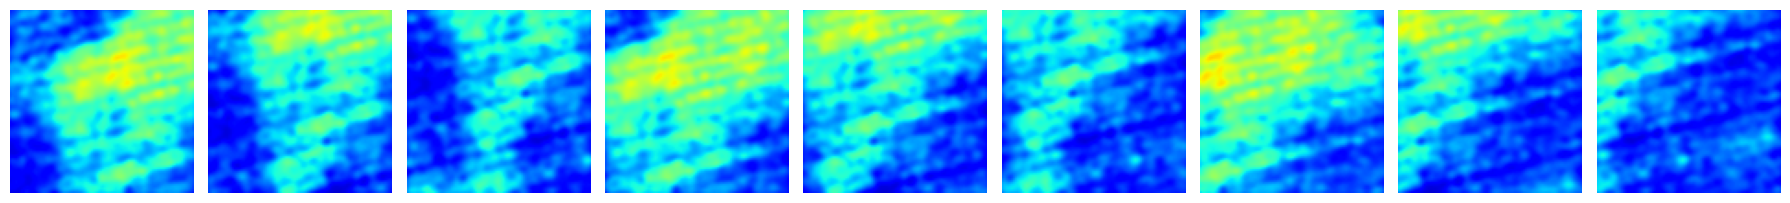

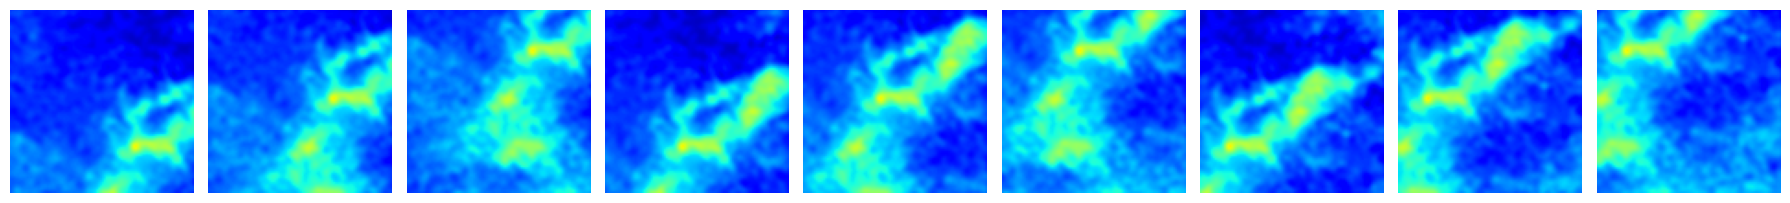

In [13]:
COLS = 9
rows = (len(bubble_data) + COLS - 1) // COLS
data_index = 0

for line in range(rows):
    fig, axes = plt.subplots(1, COLS, figsize=(2 * COLS, 3))
    axes_flat = axes.flatten()
    
    for k in range(COLS):
        if data_index < len(bubble_data):
            data_num = data_index
                        
            ax = axes_flat[k]
            data = bubble_data[data_num]
            
            ax.imshow(np.sum(data, axis=0), cmap="jet", vmin=0, vmax=7) 
            # ax.set_title(f"{combinations[k]}")
            ax.axis("off")
            
            data_index += 1
        else:
            axes_flat[k].axis("off")

    plt.tight_layout()
    # plt.savefig(f"No.{line}.png")
    plt.show()

In [14]:
data = np.concatenate((bubble_data, removal_data))
label = np.concatenate((bubble_label, removal_label))

In [15]:
len(data)

565

In [16]:
# label

In [17]:
# data = torch.from_numpy(data).float()
# train_data, val_data, train_labels, val_labels = train_test_split(
#     data, label, test_size=0.2, random_state=42, stratify=label
# )
# val_data, test_data, val_labels, test_labels = train_test_split(
#     val_data, val_labels, test_size=0.25, random_state=42, stratify=val_labels)

# train_dataset    = DataSet(train_data, train_labels)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_dataset      = DataSet(val_data, val_labels)
# val_dataloader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
# dataloader_dic   = {"train": train_dataloader, "val": val_dataloader}

test_dataset = DataSet(data, label)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [39]:
model.to(device)

# --- 変数の初期化 ---
test_correct_preds = 0
test_total_samples = 0
test_true_positives = 0
test_actual_positives = 0
test_predicted_positives = 0  # 【追加】モデルがPositive(1)と予測した総数

predicted_list = []

# テストループ
for images, labels in tqdm(test_dataloader):
    # バッチサイズを維持したままチャンネル数を1に設定
    images = images.view(-1, 1, 30, 100, 100)
    labels = labels.to(device).float()
    
    # 【注】推論時は通常 torch.no_grad() を推奨しますが、元のコードに合わせています
    with torch.set_grad_enabled(True):
        # モデルの出力を計算する
        images = images.float()
        output, latent = model(images.clone().to(device))
        output = output.squeeze()
        
        # 閾値0.5で0/1に変換
        predicted = (output > 0.5).float()
        # print(predicted) # デバッグ用出力（必要に応じてコメントアウト）

        predicted_list.extend(predicted.clone().detach().cpu().numpy().tolist())
        
        if False in (predicted == labels):
            print("!!")
        
        # 1. Accuracy用
        test_correct_preds += (predicted == labels).sum().item()
        test_total_samples += labels.size(0)
                    
        # 2. Recall用 (分子: TP, 分母: 実際の正例数)
        test_true_positives += ((predicted == 1) & (labels == 1)).sum().item()
        test_actual_positives += (labels == 1).sum().item()

        # 3. Precision用 【追加】 (分母: 予測した正例数)
        test_predicted_positives += (predicted == 1).sum().item()

# --- スコア計算 ---
# Accuracy
test_accuracy = test_correct_preds / test_total_samples if test_total_samples > 0 else 0.0

# Recall = TP / (TP + FN) = TP / Actual Positives
test_recall = test_true_positives / test_actual_positives if test_actual_positives > 0 else 0.0

# Precision = TP / (TP + FP) = TP / Predicted Positives 【追加】
test_precision = test_true_positives / test_predicted_positives if test_predicted_positives > 0 else 0.0

# 結果の表示
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"Precision: {test_precision:.4f}")

  0%|          | 0/36 [00:00<?, ?it/s]

!!
!!
Accuracy : 0.9823
Recall   : 0.6296
Precision: 1.0000


In [26]:
print("Test Accuracy: {:.4f}, Test Recall: {:.4f}, Test Precision: {:.4f}".format(test_accuracy, test_recall, test_precision))

Test Accuracy: 0.9823, Test Recall: 0.6296, Test Precision: 1.0000


In [24]:
print(f"test actual positives: {test_actual_positives}")
print(f"test true positives: {test_true_positives}")
print(f"test total samples: {test_total_samples}")
print(f"test correct preds: {test_correct_preds}")

test actual positives: 27
test true positives: 17
test total samples: 565
test correct preds: 555


# バブルデータの正誤判定確認

In [49]:
judgement_list = []
for i in predicted_list:
    jud = int(i)
    if jud == 0:
        jud = "No"
    elif jud == 1:
        jud = "Bubble"
    judgement_list.append(jud)

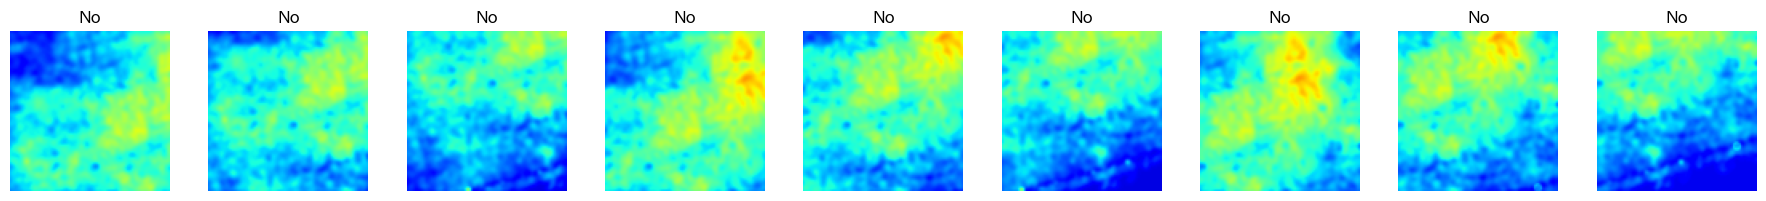

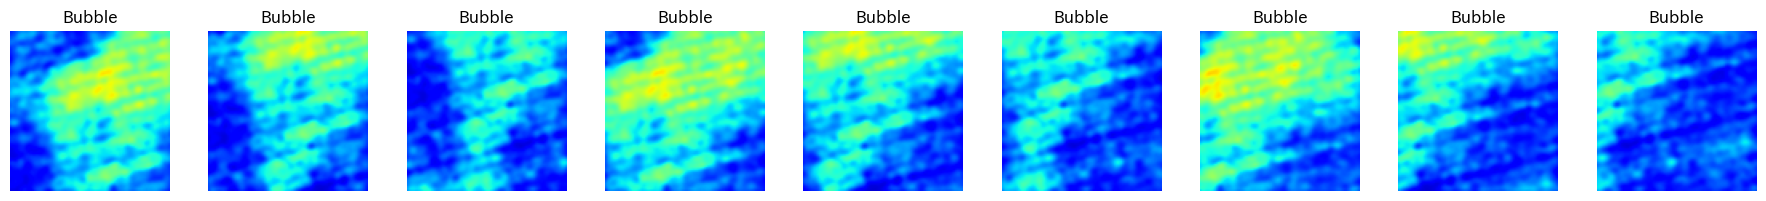

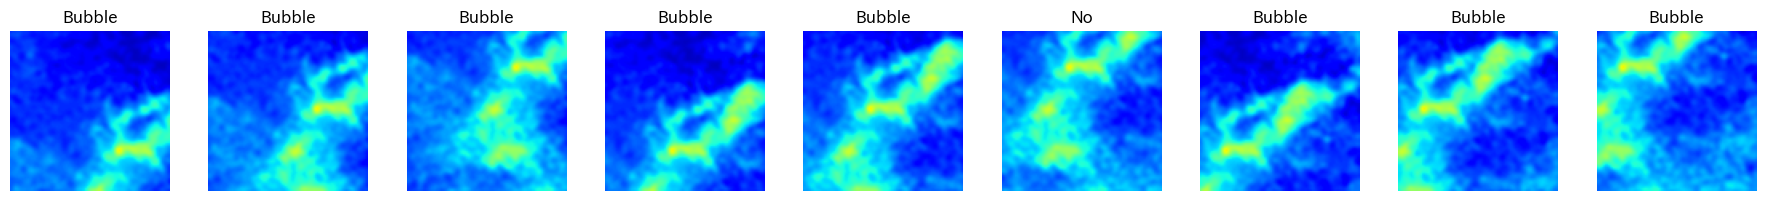

In [52]:
COLS = 9
rows = (len(bubble_data) + COLS - 1) // COLS
data_index = 0

for line in range(rows):
    fig, axes = plt.subplots(1, COLS, figsize=(2 * COLS, 2))
    axes_flat = axes.flatten()
    
    for k in range(COLS):
        if data_index < len(bubble_data):
            data_num = data_index
                        
            ax = axes_flat[k]
            data = bubble_data[data_num]
            
            ax.imshow(np.sum(data, axis=0), cmap="jet", vmin=0, vmax=7) 
            ax.set_title(f"{judgement_list[data_num]}")
            ax.axis("off")
            
            data_index += 1
        else:
            axes_flat[k].axis("off")

    plt.tight_layout()
    plt.savefig(f"No.{line}.png")
    plt.show()